# Notebook for testing different functions and methods.

In [2]:
# Import other files
import piracy_classes
import piracy_main

In [3]:
# Import modules
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geodatasets
import folium

In [ ]:
# Run main portion of piracy_main. Will just build a vessel dictionary and make a generic map
%run piracy_main.py

### Plot points according to oceanic region
Reference 1: https://www.matecdev.com/posts/point-in-polygon.html
Reference 2: https://geopandas.org/en/stable/gallery/plotting_with_folium.html

In [13]:
# Open the shapefile
oceans = gpd.GeoDataFrame.from_file('Map_Files/Oceans_shpfile_GOaS_v1_20211214/goas_v01.shp')

# Get dataframe with lat/lon points
piracy_df_original = pd.read_csv('Data_Files/[Clean] IMO Piracy - 2000 to 2022 (PDV 01-2023).csv')

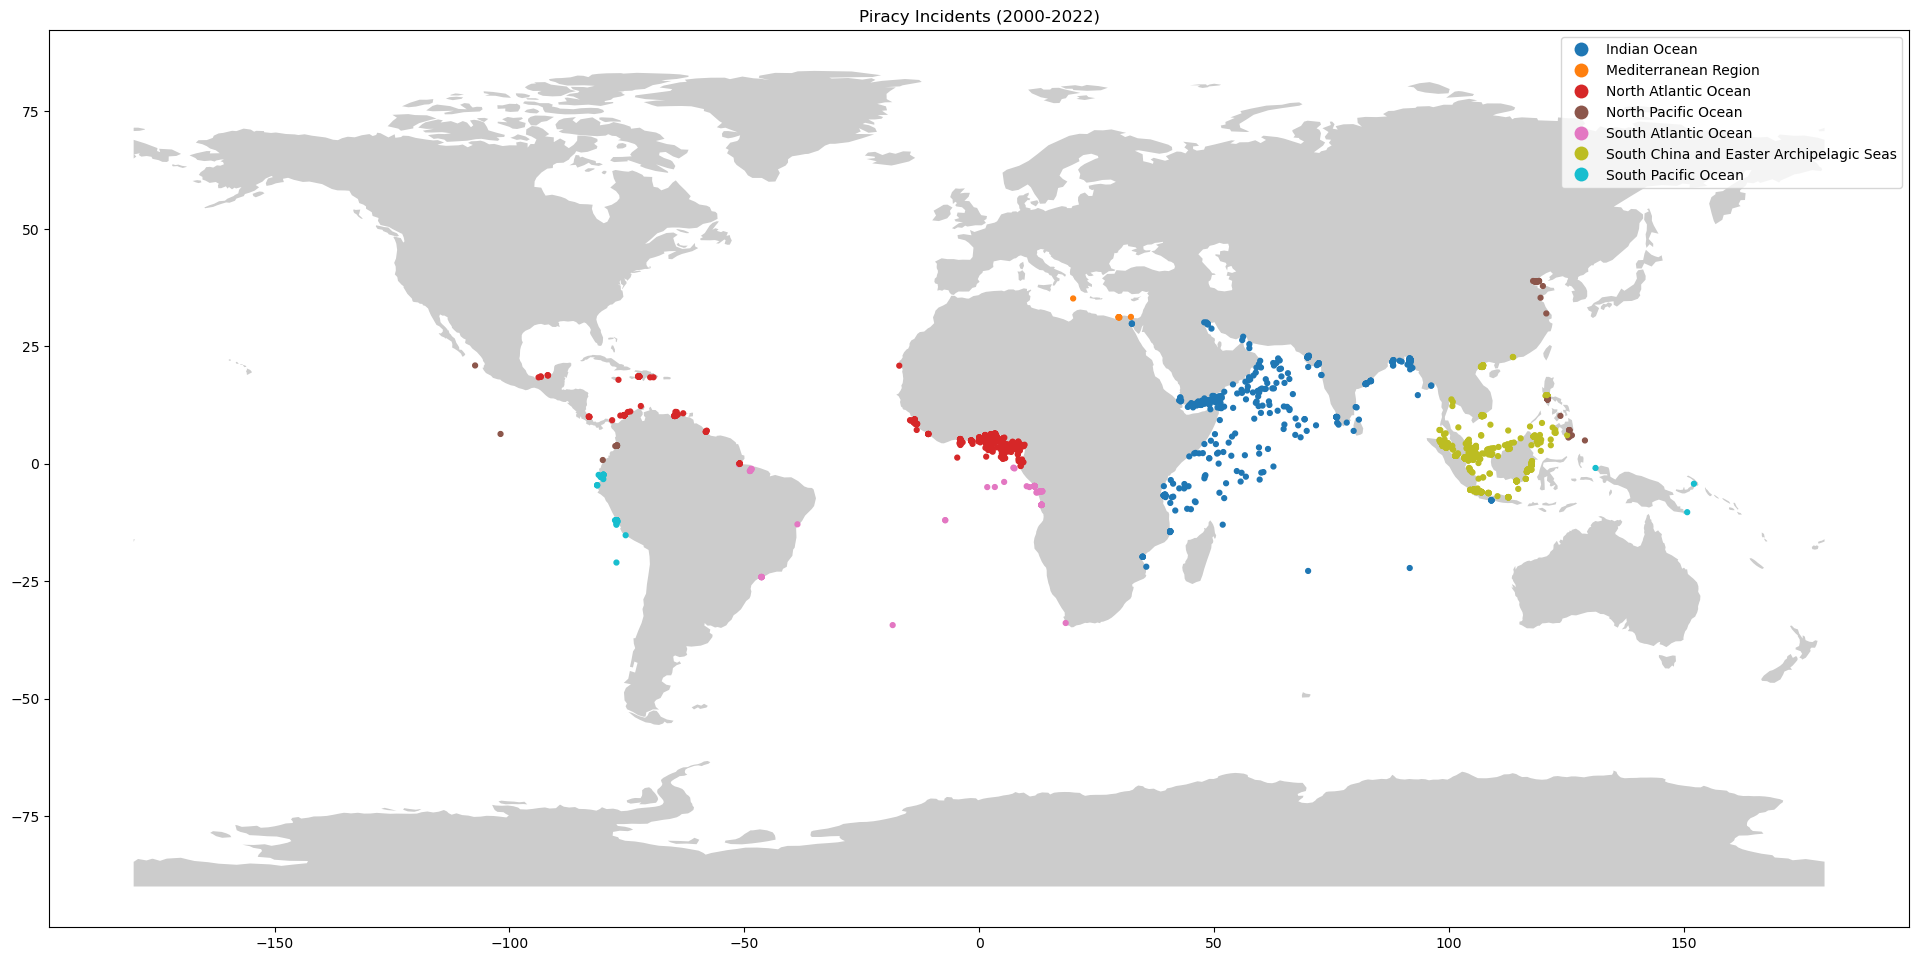

In [14]:
# Zip coordinate points together into their own row
piracy_df_original['coord'] = list(zip(piracy_df_original['Longitude'], piracy_df_original['Latitude']))
piracy_df_original = piracy_df_original.dropna(axis=0, subset=['Latitude', 'Longitude'])
piracy_df_original['coord'] = piracy_df_original['coord'].apply(Point)
points = gpd.GeoDataFrame(piracy_df_original, geometry='coord', crs=oceans.crs)

# Spacial join to match points and polygons
pointInPolys = gpd.tools.sjoin(points, oceans, predicate='within', how='left')

# Generate geometry (points to plot) and geo_df to prepare for mapping
geometry = gpd.points_from_xy(piracy_df_original.Longitude, piracy_df_original.Latitude)
geo_df = gpd.GeoDataFrame(pointInPolys, geometry=geometry)

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(24, 18))
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Plot base map
world.plot(ax=ax, alpha=0.4, color="grey")

# Plot 
geo_df.plot(column='name', ax=ax, markersize=12, legend=True)
plt.title('Piracy Incidents (2000-2022)')
plt.show()

### Create interactive map with Folium
Reference: https://geopandas.org/en/stable/gallery/plotting_with_folium.html

In [ ]:
# Start map
map = folium.Map(tiles="CartoDB Positron", zoom_start=9)

# Create a geometry list from the GeoDataFrame (uses geo_df from above)
geo_df_mask = geo_df[~geo_df.is_empty]  # Constrain out empty points
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df_mask.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
for i, coordinates in enumerate(geo_df_list):
    # assign a color marker for the location
    if geo_df_mask['name'].iloc[i] == "South China and Easter Archipelagic Seas":
        type_color = "green"
    elif geo_df_mask['name'].iloc[i] == "Indian Ocean":
        type_color = "blue"
    elif geo_df_mask['name'].iloc[i] == "South Pacific Ocean":
        type_color = "orange"
    elif geo_df_mask['name'].iloc[i] == "North Pacific Ocean":
        type_color = "pink"
    else:
        type_color = "purple"

    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup="- Date: "
                  + str(getattr(geo_df_mask.iloc[i], 'Incident Date'))
                  + "<br>"
                  + "- Ship Name: "
                  + str(getattr(geo_df_mask.iloc[i], 'Ship Name'))
                  + "<br>"
                  + "- Ship Flag: "
                  + str(getattr(geo_df_mask.iloc[i], 'Ship Flag'))
                  + "<br>"
                  + "- Ship Type: "
                  + str(getattr(geo_df_mask.iloc[i], 'Ship Type'))
                  + "<br>"
                  + "- Coordinates: "
                  + str(geo_df_list[i]),
            icon=folium.Icon(color="%s" % type_color),
        )
    )

# Save map
map.save('Data_Files/Results/InteractiveMap.html')

# Show map
# map